In [1]:
import torch
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
print(f"CUDA version: {torch.version.cuda}")  # Should match your nvcc version (12.1)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")  # Should return True

CUDA version: 12.1
PyTorch version: 2.5.0+cu121
CUDA available: True


In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

### Importing data

In [3]:
import os

dataset_dir = 'dataset'
# pdg == parkinson's disease group
# cg == control group

pdg_dir = dataset_dir + '/t2/pd_t2_sagital/'
pdg_file_paths = [
    pdg_dir + file_path for file_path in os.listdir(pdg_dir)
    if file_path.endswith('.nii')
    and os.path.isfile(os.path.join(pdg_dir, file_path))
    ]
pdg_file_paths = pdg_file_paths[:91]
print("Parkinson's Disease Group Files with extension, .nii:", len(pdg_file_paths))

cg_dir = dataset_dir + '/t2/control_t2_sagital/'
cg_file_paths = [
    cg_dir + file_path for file_path in os.listdir(cg_dir)
    if file_path.endswith('.nii')
    and os.path.isfile(os.path.join(cg_dir, file_path))
    ]

print("Control Group Files with extension, .nii:", len(cg_file_paths))

Parkinson's Disease Group Files with extension, .nii: 91
Control Group Files with extension, .nii: 91


### Loading data and preprocessing

In [4]:
import nibabel as nib
import numpy as np

from scipy import ndimage

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def zscore_normalize(volume):
    if volume.ndim > 3:
        volume = volume[:, :, :, 0]

    mean    = np.mean(volume)
    std     = np.std(volume)
    volume  = (volume - mean) / std
    return volume.astype("float32")

def min_max_normalize(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    volume = (volume - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero
    return volume.astype("float32")

def resize_volume(img, filepath):
    # Set desired dimensions
    desired_depth   = 64
    desired_width   = 128
    desired_height  = 128

    # Get current dimensions
    current_depth   = img.shape[-1]
    current_width   = img.shape[0]
    current_height  = img.shape[1]

    # Compute factors
    depth   = current_depth / desired_depth
    width   = current_width / desired_width
    height  = current_height / desired_height
    depth_factor    = 1 / depth
    width_factor    = 1 / width
    height_factor   = 1 / height

    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    print(f'No. of dimensions: {img.ndim}')
    print(f'Lenght: {len(img)}')
    print(f"Image shape: {img.shape}")
    print(f"Scaling factors: {(width_factor, height_factor, depth_factor)}")
    print(filepath)
    print('-------------------------')

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    #volume = zscore_normalize(volume)
    #volume = min_max_normalize(volume)
    volume = resize_volume(volume, path)
    return volume

### Building Train and Test datasets

In [5]:
pdg_array   = np.array([process_scan(path) for path in pdg_file_paths])
cg_array    = np.array([process_scan(path) for path in cg_file_paths])

pdg_labels  = np.array([1 for _ in range(len(pdg_array))])
cg_labels   = np.array([0 for _ in range(len(cg_array))])

No. of dimensions: 3
Lenght: 192
Image shape: (192, 256, 256)
Scaling factors: (0.6666666666666666, 0.5, 0.25)
dataset/t2/pd_t2_sagital/I1473191_Anon_20201007135132_6.nii
-------------------------
No. of dimensions: 3
Lenght: 188
Image shape: (188, 256, 256)
Scaling factors: (0.6808510638297872, 0.5, 0.25)
dataset/t2/pd_t2_sagital/I1473202_Anon_20210219102304_7.nii
-------------------------
No. of dimensions: 3
Lenght: 192
Image shape: (192, 256, 256)
Scaling factors: (0.6666666666666666, 0.5, 0.25)
dataset/t2/pd_t2_sagital/I1473275_3D_T2_SAG_FLAIR_20210330131508_7.nii
-------------------------
No. of dimensions: 3
Lenght: 192
Image shape: (192, 256, 256)
Scaling factors: (0.6666666666666666, 0.5, 0.25)
dataset/t2/pd_t2_sagital/I1473692_Anon_20201222125134_6.nii
-------------------------
No. of dimensions: 3
Lenght: 192
Image shape: (192, 256, 256)
Scaling factors: (0.6666666666666666, 0.5, 0.25)
dataset/t2/pd_t2_sagital/I1490375_Anon_20201112160113_6.nii
-------------------------
No. 

In [6]:
from sklearn.model_selection import train_test_split

x = np.concatenate((pdg_array, cg_array), axis=0)
y = np.concatenate((pdg_labels, cg_labels), axis=0)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
print(type(y_train))

<class 'numpy.ndarray'>


In [8]:
print(y_train)

[0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0]


### Data Augmentation

##### TorchIO

In [9]:
import torchio as tio

train_transform = tio.Compose([
    #tio.CropOrPad(target_shape=(32, 128, 128)),  # Crop or pad to 64x64x32

    tio.RandomFlip(axes=(0), p=0.5),
    tio.RandomAffine(scales=(0.95, 1.05), degrees=(5, 5, 5), translation=(3, 3, 3), p=0.5),
    tio.RandomNoise(std=(0, 0.005), p=0.2),
    tio.RandomBiasField(coefficients=0.3, p=0.2),
    tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.2),
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.ZNormalization()
])

test_transform = tio.Compose([
    #tio.CropOrPad(target_shape=(32, 128, 128)),  # Crop or pad to 64x64x32
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.ZNormalization()
])

c:\Users\dante\OneDrive\Documentos\Projects\Parkinson-MRI\parkinson-mri\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Custom PyTorch Dataset

In [10]:
from torch.utils.data import Dataset

class ParkinsonMRIDataset(Dataset):
    def __init__(self, volumes, labels, transform=None):
        self.volumes = volumes
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.volumes)
    
    def __getitem__(self, idx):
        volume = self.volumes[idx]
        label = self.labels[idx]

        volume = np.expand_dims(volume, axis=0).astype(np.float32)  # [1, H, W, D]
        volume = np.transpose(volume, (0, 3, 1, 2))  # → [1, D, H, W]

        subject = tio.Subject(
            mri = tio.ScalarImage(tensor=volume),
            label = label
        )

        if self.transform:
            subject = self.transform(subject)

        img_tensor = subject['mri'].data
        label_tensor = torch.tensor([label], dtype=torch.float32)

        return img_tensor, label_tensor

#### DataLoader Setup

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

train_dataset   = ParkinsonMRIDataset(x_train, y_train, transform=train_transform)
test_dataset    = ParkinsonMRIDataset(x_test, y_test, transform=test_transform)
print("Train dataset shape:", train_dataset[0][0].shape)
print("Test dataset shape:", test_dataset[0][0].shape)

class_counts = np.bincount(y_train)
weights = 1.0 / class_counts
samples_weights = weights[y_train]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

batch_size = 2

train_loader = DataLoader(
    #train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0#, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0#, pin_memory=True
)

Train dataset shape: torch.Size([1, 64, 128, 128])
Test dataset shape: torch.Size([1, 64, 128, 128])


In [12]:
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

Train Dataset size: 145
Test Dataset size: 37


##### Visualize scan

Dimension of the scan is: (1, 64, 128, 128)
Label: tensor([0.])


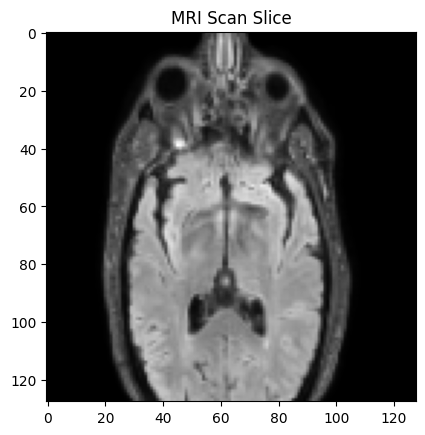

In [13]:
import matplotlib.pyplot as plt
images, labels = train_dataset[0]
images = images.numpy()
print('Dimension of the scan is:', images.shape)
print(f'Label: {labels}')
plt.imshow(np.squeeze(images[:, 32, :, :]), cmap="gray")
plt.title("MRI Scan Slice")
plt.show()

Dimension of the scan is: (1, 64, 128, 128)
Label: tensor([1.])


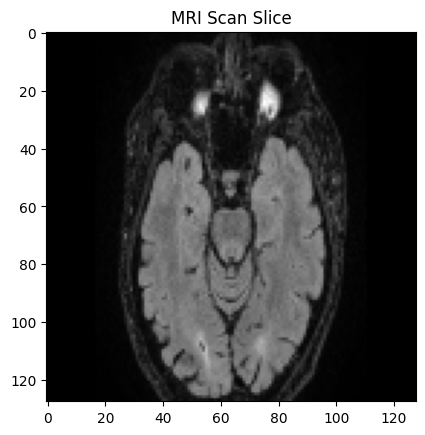

In [14]:
import matplotlib.pyplot as plt
images, labels = test_dataset[1]
images = images.numpy()
print('Dimension of the scan is:', images.shape)
print(f'Label: {labels}')
plt.imshow(np.squeeze(images[0, 32, :, :]), cmap="gray")
plt.title("MRI Scan Slice")
plt.show()

### Define a 3D Convolutional Neural Network

### Load pre-trained model

In [15]:
from torchvision.models.video import r3d_18
model = r3d_18(pretrained=True)

c:\Users\dante\OneDrive\Documentos\Projects\Parkinson-MRI\parkinson-mri\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dante\OneDrive\Documentos\Projects\Parkinson-MRI\parkinson-mri\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchinfo

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    #nn.Sigmoid(),
)

for param in model.parameters(): # Unfreeze all parameters
    param.requires_grad = True

In [17]:
# Modify input layer for 1-channel input
bias = model.stem[0].bias is not None,
model.stem[0] = nn.Conv3d(
    in_channels=1,
    out_channels=model.stem[0].out_channels,
    kernel_size=model.stem[0].kernel_size,
    stride=model.stem[0].stride,
    padding=model.stem[0].padding,
    bias=bias
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


### Train model

##### Model definition

In [18]:
import torch
import torch.optim as optim
from  torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Initialize model, loss function, optimizer and scheduler
#model = ParkinsonCNN()
#criterion = nn.BCELoss() # Binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss with logits
initial_lr = 0.000005
#optimizer = optim.Adam(model.parameters(), lr=initial_lr)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=initial_lr, weight_decay=1e-5)
#scheduler = ExponentialLR(optimizer, gamma=0.96) # Decay rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
# Moving model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d

In [19]:
parameters = model.parameters()
paramenter_count = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {paramenter_count}')

Number of parameters: 33410689


##### Training Function

In [20]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #preds = (outputs > 0.5).float()
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels.view(-1, 1)).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

##### Test Function

In [21]:
def test_epoch(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            
            test_loss += loss.item()
            #preds = (outputs > 0.5).float()
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.view(-1, 1)).sum().item()
            total += labels.size(0)
        
    test_loss /= len(test_loader)
    test_acc = correct / total
    return test_loss, test_acc

In [22]:
for inputs, labels in train_loader:
    print("Inputs shape:", inputs.shape)  # Should be [batch_size, 1, 128, 128, 64]
    print("Labels shape:", labels.shape)  # Should be [batch_size, 1]
    print("Unique labels:", torch.unique(labels))  # Should only show [0, 1]
    break

c:\Users\dante\OneDrive\Documentos\Projects\Parkinson-MRI\parkinson-mri\lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


Inputs shape: torch.Size([2, 1, 64, 128, 128])
Labels shape: torch.Size([2, 1])
Unique labels: tensor([0., 1.])


##### Training Loop (early stopping and checkpoints)

In [23]:
epochs = 100

# Define early stopping and checkpoint variables
best_test_acc = 0
early_stop_count = 0
patience = 20 # Number of epochs with no improvement to trigger early stopping

train_acc_list = list()
train_loss_list = list()
test_acc_list = list()
test_loss_list = list()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_epoch(model, test_loader, criterion)

    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

    # Learning rate scheduling
    scheduler.step(test_loss)

    # Checkpoint: Save the best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        early_stop_count = 0
        torch.save(model.state_dict(), 'parkinson_classification_RESNET.pth')
        print("Model checkpoint saved!")
    else:
        early_stop_count += 1
    
    #Early stopping
    if early_stop_count >= patience:
        print("Early stopping triggered")
        print(f"Best Test Accuracy: {best_test_acc:.4f}")
        break

Epoch 1/100
Train loss: 0.7327, Train accuracy: 0.4345
Test loss: 0.6954, Test accuracy: 0.4865
Model checkpoint saved!
Epoch 2/100
Train loss: 0.7009, Train accuracy: 0.4690
Test loss: 0.6830, Test accuracy: 0.6216
Model checkpoint saved!
Epoch 3/100
Train loss: 0.6914, Train accuracy: 0.5241
Test loss: 0.6823, Test accuracy: 0.4595
Epoch 4/100
Train loss: 0.6874, Train accuracy: 0.5724
Test loss: 0.6744, Test accuracy: 0.5405
Epoch 5/100
Train loss: 0.6697, Train accuracy: 0.5862
Test loss: 0.6698, Test accuracy: 0.5135
Epoch 6/100
Train loss: 0.6613, Train accuracy: 0.6207
Test loss: 0.6546, Test accuracy: 0.5946
Epoch 7/100
Train loss: 0.6846, Train accuracy: 0.5586
Test loss: 0.6586, Test accuracy: 0.5676
Epoch 8/100
Train loss: 0.6695, Train accuracy: 0.5931
Test loss: 0.6579, Test accuracy: 0.5946
Epoch 9/100
Train loss: 0.6513, Train accuracy: 0.6483
Test loss: 0.6474, Test accuracy: 0.6486
Model checkpoint saved!
Epoch 10/100
Train loss: 0.6590, Train accuracy: 0.6276
Test los

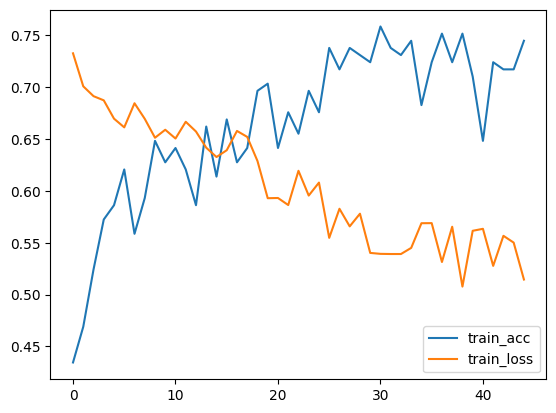

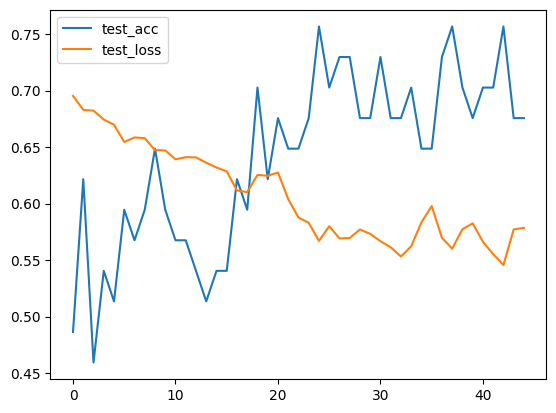

In [30]:
import matplotlib.pyplot as plt
plt.plot(train_acc_list, label='train_acc')
plt.plot(train_loss_list, label='train_loss')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
plt.plot(test_acc_list, label='test_acc')
plt.plot(test_loss_list, label='test_loss')
plt.legend()
plt.show()

#### Load trained model

In [25]:
import torch
model.load_state_dict(torch.load('parkinson_classification_RESNET_TORCHIO.pth'))
model.eval()

C:\Users\dante\AppData\Local\Temp\ipykernel_7792\3817155333.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('parkinson_classification_RE

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d

No. of dimensions: 3
Lenght: 192
Image shape: (192, 256, 256)
Scaling factors: (0.6666666666666666, 0.5, 0.25)
dataset/t2/control_t2_sagital/I11037285_Anon_20241023173743_12.nii
-------------------------
Dimension of the scan is: torch.Size([1, 64, 128, 128])


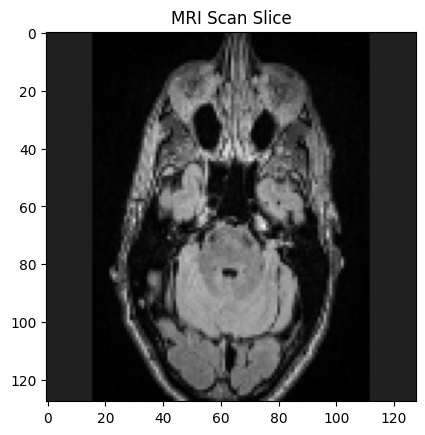

Model output: tensor([[-3.1213]], device='cuda:0', grad_fn=<AddmmBackward0>)
Prediction: 0
Control Group


In [26]:
import nibabel as nib
import numpy as np

from scipy import ndimage

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def zscore_normalize(volume):
    if volume.ndim > 3:
        volume = volume[:, :, :, 0]

    mean    = np.mean(volume)
    std     = np.std(volume)
    volume  = (volume - mean) / std
    return volume.astype("float32")

def min_max_normalize(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    volume = (volume - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero
    return volume.astype("float32")

def resize_volume(img, filepath):
    # Set desired dimensions
    desired_depth   = 64
    desired_width   = 128
    desired_height  = 128

    # Get current dimensions
    current_depth   = img.shape[-1]
    current_width   = img.shape[0]
    current_height  = img.shape[1]

    # Compute factors
    depth   = current_depth / desired_depth
    width   = current_width / desired_width
    height  = current_height / desired_height
    depth_factor    = 1 / depth
    width_factor    = 1 / width
    height_factor   = 1 / height

    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    print(f'No. of dimensions: {img.ndim}')
    print(f'Lenght: {len(img)}')
    print(f"Image shape: {img.shape}")
    print(f"Scaling factors: {(width_factor, height_factor, depth_factor)}")
    print(filepath)
    print('-------------------------')

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = zscore_normalize(volume)
    #min_max_normalize(volume)
    volume = resize_volume(volume, path)
    return volume

#nifti_file = 'dataset/t2/pd_t2_sagital/I1490509_Anon_20210302144514_6.nii'
nifti_file = 'dataset/t2/control_t2_sagital/I11037285_Anon_20241023173743_12.nii'
nifti_array = np.array(process_scan(nifti_file))

volume = nifti_array
#volume[volume < 0] = 0
#volume[volume > 1] = 1
volume = torch.Tensor(volume).unsqueeze(0)
volume = np.transpose(volume, (0, 3, 1, 2))  # → [1, D, H, W]

import matplotlib.pyplot as plt

print('Dimension of the scan is:', volume.shape)
plt.imshow(np.squeeze(volume[0, 32, :, :]), cmap="gray")
plt.title("MRI Scan Slice")
plt.show()

volume = volume.unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform inference
output = model(volume.to(device))

print(f"Model output: {output}")

# Threshold at 0.5 for binary classification
pred = 1 if output.item() > 0.5 else 0
print(f"Prediction: {pred}")

# Interpret the prediction
if pred == 1:
    print('Parkinson’s Disease')
else:
    print('Control Group')

In [27]:
logits_list = list()
prob_list = list()
model.eval()
with torch.no_grad():
    for volume, label in test_loader:
        volume = volume.to(device)
        
        output = model(volume)
        logits = output
        logits_list.append(np.array(output.to('cpu')).squeeze(1))

        #probabilities = torch.sigmoid(logits) if logits.shape[1] == 1 else torch.softmax(logits, dim=1)
        #prob_list.append(probabilities)
        #preds = torch.argmax(probabilities, dim=1)
        #print(f"Logits: {logits}, Probabilities: {probabilities}, Predictions: {preds}, Ground Truth: {label}")


In [28]:
print(logits_list)

[array([-0.6044672,  1.3083081], dtype=float32), array([ 0.35265577, -1.9987731 ], dtype=float32), array([-0.17482737,  0.34428293], dtype=float32), array([ 0.4404966, -2.110747 ], dtype=float32), array([-1.8263478, -1.3372797], dtype=float32), array([-1.2254688, -1.96245  ], dtype=float32), array([-1.087666 , -1.5848205], dtype=float32), array([-0.08784372, -0.7570928 ], dtype=float32), array([-1.1098017 ,  0.01465459], dtype=float32), array([-0.6430751, -0.4057287], dtype=float32), array([-1.322038 , -1.0557731], dtype=float32), array([0.21897043, 2.1812909 ], dtype=float32), array([-3.1308954, -1.5426879], dtype=float32), array([-1.6569862, -2.5479646], dtype=float32), array([0.77362424, 1.1532058 ], dtype=float32), array([0.20778577, 1.571238  ], dtype=float32), array([ 0.5848481, -1.7885699], dtype=float32), array([ 1.0850732 , -0.11894255], dtype=float32), array([-1.0155233], dtype=float32)]


In [29]:
from sklearn.metrics import roc_curve


# Example with logits and ground truth
# Ground truth (0 = CG, 1 = PD)
logits_list = np.array(logits_list).flatten()
y_true = []
for volume, label in test_loader:
    y_true.append(label)

y_true = np.array(y_true).flatten()
print(len(y_true))
y_scores = logits_list  # Logits or probabilities
print(len(y_scores))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.